<a href="https://colab.research.google.com/github/pachterlab/CBP_2021/blob/main/notebooks/ExInUteroE105/uteroAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Read in files from NCBI GEO
!wget --quiet https://ftp.ncbi.nlm.nih.gov/geo/series/GSE149nnn/GSE149372/suppl/GSE149372_GSM5068636-GSM5068641_scRNA.MetaData.105.csv.gz
!wget --quiet https://ftp.ncbi.nlm.nih.gov/geo/series/GSE149nnn/GSE149372/suppl/GSE149372_GSM5068636-GSM5068641_scRNA.normalized.assay105.csv.gz
!wget --quiet https://ftp.ncbi.nlm.nih.gov/geo/series/GSE149nnn/GSE149372/suppl/GSE149372_GSM5068636-GSM5068641_scRNA.integrated.scaled.assay105.csv.gz

!wget --quiet https://ftp.ncbi.nlm.nih.gov/geo/series/GSE149nnn/GSE149372/suppl/GSE149372_scRNA.MetaData.85.csv.gz
!wget --quiet https://ftp.ncbi.nlm.nih.gov/geo/series/GSE149nnn/GSE149372/suppl/GSE149372_scRNA.normalized.assay85.csv.gz

#integrated.scaled.assay105

In [2]:
!gunzip *.gz

In [3]:
!git clone https://github.com/hhcho/densvis.git

Cloning into 'densvis'...
remote: Enumerating objects: 145, done.
remote: Counting objects: 100% (145/145), done.
remote: Compressing objects: 100% (95/95), done.
remote: Total 145 (delta 78), reused 100 (delta 45), pack-reused 0
Receiving objects: 100% (145/145), 410.98 KiB | 9.56 MiB/s, done.
Resolving deltas: 100% (78/78), done.


In [4]:
%cd /content/densvis/densne/

/content/densvis/densne


In [5]:
!g++ sptree.cpp densne.cpp densne_main.cpp -o den_sne -O2
import densne

densne.cpp: In function ‘bool DENSNE::load_data(double**, int*, int*, int*, double*, double*, int*, int*, double*, double*, bool*, double**)’:
densne.cpp:961:8: warning: ignoring return value of ‘size_t fread(void*, size_t, size_t, FILE*)’, declared with attribute warn_unused_result [-Wunused-result]
   fread(n, sizeof(int), 1, h);                                            // number of datapoints
   ~~~~~^~~~~~~~~~~~~~~~~~~~~~
densne.cpp:962:8: warning: ignoring return value of ‘size_t fread(void*, size_t, size_t, FILE*)’, declared with attribute warn_unused_result [-Wunused-result]
   fread(d, sizeof(int), 1, h);                                            // original dimensionality
   ~~~~~^~~~~~~~~~~~~~~~~~~~~~
densne.cpp:963:8: warning: ignoring return value of ‘size_t fread(void*, size_t, size_t, FILE*)’, declared with attribute warn_unused_result [-Wunused-result]
   fread(theta, sizeof(double), 1, h);                                        // gradient accuracy
   ~~~~~^~~~~~~~~~

In [6]:
%cd /content/

/content


In [7]:
!git clone https://github.com/pachterlab/CBP_2021.git

Cloning into 'CBP_2021'...
remote: Enumerating objects: 340, done.
remote: Counting objects: 100% (340/340), done.
remote: Compressing objects: 100% (301/301), done.
remote: Total 340 (delta 195), reused 91 (delta 25), pack-reused 0
Receiving objects: 100% (340/340), 51.76 MiB | 23.57 MiB/s, done.
Resolving deltas: 100% (195/195), done.


In [8]:
%cd /content/CBP_2021/scripts

/content/CBP_2021/scripts


In [9]:
!pip3 install --quiet torch
!pip3 install --quiet anndata
!pip3 install --quiet matplotlib
!pip3 install --quiet scikit-learn
!pip3 install --quiet torchsummary
!pip install --quiet scanpy==1.7.0rc1
!pip3 install --quiet umap-learn

     |████████████████████████████████| 127 kB 5.1 MB/s 
     |████████████████████████████████| 10.2 MB 4.7 MB/s 
     |████████████████████████████████| 69 kB 7.2 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 


## **Install Packages**

In [36]:
import statistics
import anndata 
import pandas as pd
import numpy as np
from MCML import MCML #Now has continuous label addition
from Picasso import Picasso
import visualizations as vis
import tools as tl
import random
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.neighbors import NeighborhoodComponentsAnalysis, NearestNeighbors
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import scale
import torch
import time
import scanpy as sc
import seaborn as sns
import umap
from scipy import stats
import scipy.io as sio
import matplotlib
matplotlib.rc('axes',edgecolor='black')
%matplotlib inline
sc.set_figure_params(dpi=125)
#sns.set_style('white')


## **Analysis of E10.5 Data**

In [11]:
# General parameters
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['axes.linewidth'] = 0.1

state = 42
ndims = 2

data_path = '/content'

n_latent = 50
pcs = 15
pcs2 = 15

In [12]:
def readLgMat(fname, data_path='/content'):

  col_names = pd.read_csv(data_path+fname, nrows=0).columns
  types_dict = {'Unnamed: 0': str}
  types_dict.update({col: np.float16 for col in col_names if col not in types_dict})

  chunk = pd.read_csv(data_path+fname,chunksize=1000,index_col=0,dtype=types_dict)
  counts = pd.concat(chunk)

  return counts

Read in Seurat-Integrated, 'Variance-Stabilized' and Scaled counts

In [13]:
# fname = '/GSE149372_GSM5068636-GSM5068641_scRNA.integrated.scaled.assay105.csv' #'/GSE149372_GSM5068636-GSM5068641_scRNA.normalized.assay105.csv'

counts = readLgMat('/GSE149372_GSM5068636-GSM5068641_scRNA.integrated.scaled.assay105.csv')
counts.head()

,AAACCCAAGCCTCACG-1,AAACCCAAGCTCGACC-1,AAACCCAAGTTAACAG-1,AAACCCACACCATATG-1,AAACCCAGTCACGCTG-1,AAACCCAGTGCGTTTA-1,AAACCCAGTGGCTCTG-1,AAACCCATCCCATAGA-1,AAACGAAAGAAGCTCG-1,AAACGAAAGACTAAGT-1,AAACGAACACCATTCC-1,AAACGAACATCGCCTT-1,AAACGAAGTAGCGCTC-1,AAACGAAGTTCGGTAT-1,AAACGAATCTGGGATT-1,AAACGCTAGAGACAAG-1,AAACGCTAGATGTTAG-1,AAACGCTAGGGCCAAT-1,AAACGCTAGTAGAGTT-1,AAACGCTCAGACCCGT-1,AAACGCTCAGTGCCTG-1,AAACGCTCATTGCAAC-1,AAACGCTGTTTCCATT-1,AAAGAACCACATGGTT-1,AAAGAACCAGGTCAGA-1,AAAGAACGTCCTGGTG-1,AAAGAACTCCACAGGC-1,AAAGAACTCCACTGGG-1,AAAGAACTCTACAGGT-1,AAAGAACTCTCCGAGG-1,AAAGGGCAGAGGGTAA-1,AAAGGGCAGCAAACAT-1,AAAGGGCAGGATTTAG-1,AAAGGGCCAAGATTGA-1,AAAGGGCCAGCCTACG-1,AAAGGGCGTTTACTGG-1,AAAGGTAAGTAATTGG-1,AAAGGTACAACACTAC-1,AAAGGTACAACTACGT-1,AAAGGTAGTAGTCGTT-1,...,TTTCACAAGGAGCAAA-12,TTTCACACACTCTAGA-12,TTTCACATCCATGATG-12,TTTCACATCTGCTCTG-12,TTTCAGTTCATGCATG-12,TTTCATGCAGATAAAC-12,TTTCATGTCACGATCA-12,TTTCCTCAGACCATTC-12,TTTCCTCAGTAGCATA-12,TTTCCTCCAAACACCT-12,TTTCCTCGTAACCAGG-12,TTTCCTCGTGGCTGCT-12,TTTCCTCTCTTCGTAT-12,TTTCGATAGAAGCGAA-12,TTTCGATAGGCTAAAT-12,TTTCGATGTGGGACAT-12,TTTGACTCACACAGAG-12,TTTGACTCAGCTATAC-12,TTTGACTGTAGTCTTG-12,TTTGACTGTGGCTGCT-12,TTTGACTGTTTCGCTC-12,TTTGACTTCTGACAGT-12,TTTGATCAGGACACTG-12,TTTGATCCACACTGGC-12,TTTGATCCAGGAATAT-12,TTTGATCCAGTCGCAC-12,TTTGATCGTGAGAGGG-12,TTTGATCTCACGGGCT-12,TTTGATCTCATAAGGA-12,TTTGGAGGTGGAGGTT-12,TTTGGAGTCCCGAGTG-12,TTTGGTTAGTCTAACC-12,TTTGGTTCACAAAGCG-12,TTTGGTTGTATGAGGC-12,TTTGGTTTCGTGGCTG-12,TTTGTTGAGCAGCGAT-12,TTTGTTGCAGTCCGTG-12,TTTGTTGCAGTTCACA-12,TTTGTTGGTCGTGTTA-12,TTTGTTGTCCAACCAA-12
Hba-a1,-0.366699,-0.303711,-0.294678,2.830078,3.193359,-0.350342,2.978516,-0.426758,-0.448486,-0.161011,-0.243408,0.163330,-0.368408,-0.415283,-0.235474,-0.339844,-0.275146,-0.337158,-0.244507,-0.364258,-0.407227,-0.208984,-0.457520,-0.376221,-0.240601,-0.386230,-0.298584,3.244141,3.070312,-0.411865,-0.335693,-0.401367,-0.304932,-0.334229,-0.375000,-0.452148,-0.409424,-0.050507,-0.393799,-0.235474,...,-0.375000,-0.200317,-0.285889,-0.486084,-0.471924,-1.012695,-0.324463,-0.333008,0.126221,-0.297363,-0.264404,-0.510742,-0.324463,-0.333252,-0.352295,-0.361328,-0.313965,-0.236328,-0.451172,-0.424805,-0.314453,-0.260010,-0.184082,-0.066895,-0.475342,-0.706543,3.146484,-0.329102,2.525391,0.549316,-0.313965,-0.265381,-0.435791,-0.354004,-0.579102,-0.314209,2.933594,-0.290771,-0.413330,-0.441895
Hbb-bh1,-0.391846,-0.164429,-0.295654,2.917969,3.232422,-0.368408,2.914062,-0.369385,-0.449463,-0.322998,-0.338623,-0.439453,-0.353516,-0.407227,-0.163330,0.424072,-0.298340,-0.243652,-0.282471,-0.421143,-0.476807,-0.334717,-0.338867,-0.433105,-0.418701,-0.227173,-0.215210,3.261719,2.962891,-0.138306,-0.290527,-0.329346,-0.281738,-0.191650,-0.350098,-0.418213,-0.289307,-0.267334,-0.387695,-0.371094,...,-0.030579,-0.319580,-0.270996,-0.497314,-0.665527,0.071411,-0.419434,-0.118652,-1.219727,-0.584473,-0.237061,-0.435791,-0.388428,-0.245361,-0.406006,-0.501953,-0.690918,-0.151001,-0.358154,-0.595215,-0.322021,-0.187866,0.141968,-0.441650,-0.551758,-0.188965,3.056641,-0.342041,3.683594,0.432129,-0.771973,-0.245239,-0.029694,-0.744141,-0.196533,-0.491455,2.970703,0.188110,-0.280029,-0.370117
Hba-x,0.409912,-0.145752,-0.494385,2.945312,3.166016,-0.245972,2.966797,-0.169556,-0.375977,-0.462646,-0.364014,-0.356934,-0.498535,-0.477051,-0.142090,-0.496826,-0.425537,0.051270,-0.180298,-0.363525,-0.453857,-0.462402,-0.577148,-0.507324,-0.363037,-0.065186,-0.297607,3.203125,3.076172,-0.248291,-0.075928,-0.463867,-0.430176,-0.439941,-0.462158,-0.411377,-0.457031,-0.299561,-0.315918,-0.386963,...,-0.582520,-0.390625,-0.428467,-0.225830,-0.275391,0.034668,-0.232056,-0.247925,-0.365723,-0.195557,-0.667480,-0.635254,-0.371338,-0.115662,-0.183960,-0.485596,0.444092,-0.569824,0.149414,-0.145996,-0.565430,-0.242676,-0.546387,-0.281982,-0.370361,-0.106140,2.898438,-0.346191,2.529297,-1.166992,-0.627441,-0.453369,-0.015388,-0.108826,0.317627,-0.010666,2.923828,-0.601562,-0.346924,0.152100
Gfod2,-0.947266,-0.459229,-0.254395,-0.18

In [14]:
cellMeta = pd.read_csv(data_path+'/GSE149372_GSM5068636-GSM5068641_scRNA.MetaData.105.csv')
print(cellMeta.head())

           Unnamed: 0 orig.ident  ...  percent.mt  integrated_snn_res.0.3
0  AAACCCAAGCCTCACG-1      p10.5  ...    5.526848                       7
1  AAACCCAAGCTCGACC-1      p10.5  ...    4.088439                       5
2  AAACCCAAGTTAACAG-1      p10.5  ...    3.345725                       5
3  AAACCCACACCATATG-1      p10.5  ...    4.166025                       3
4  AAACCCAGTCACGCTG-1      p10.5  ...    1.962218                       3

[5 rows x 8 columns]


In [15]:
#Center and scale data
count_mat = counts.values.T

In [16]:
adata = anndata.AnnData(X = count_mat)
adata.obs_names = list(counts.columns)
adata.var_names = list(counts.index)
adata.obs['Utero'] = pd.Categorical(cellMeta.Utero)
adata.obs['Cluster'] = pd.Categorical(cellMeta['integrated_snn_res.0.3'])
adata

AnnData object with n_obs × n_vars = 56528 × 2000
    obs: 'Utero', 'Cluster'

In [17]:
#In paper, use top 2000 HVGs and 15 PCs
adata.obsm['log'] = adata.X #Data is already scaled so 'log' here is not just log-normalized

sc.pp.scale(adata, max_value=10) #Already scaled
adata

AnnData object with n_obs × n_vars = 56528 × 2000
    obs: 'Utero', 'Cluster'
    var: 'mean', 'std'
    obsm: 'log'

In [18]:
count_mat = adata.obsm['log']
scaled_mat = adata.X

In [19]:
#Set colors for cell clusters
colors = np.random.rand(len(adata.obs['Cluster']),3)

In [20]:

labs = np.array([list(adata.obs['Cluster']),list(adata.obs['Utero'])])


Original log-normalized counts (post-Seurat integration)



In [21]:
#GSE149372_GSM5068636-GSM5068641_scRNA.normalized.assay105.csv, Only Log-normalized data, not integrated
counts2_orig = readLgMat('/GSE149372_GSM5068636-GSM5068641_scRNA.normalized.assay105.csv')
counts2 = counts2_orig.loc[list(adata.var_names)]
counts2.shape

(2000, 56528)

In [22]:
counts2_orig.shape

(21164, 56528)

In [24]:
#Center and scale log-normalized data
count_mat_orig = counts2.values.T

In [25]:
adata2 = anndata.AnnData(X = count_mat_orig)
adata2.obs_names = list(counts2.columns)
adata2.var_names = list(counts2.index)
adata2.obs['Utero'] = pd.Categorical(cellMeta.Utero)
adata2.obs['Cluster'] = pd.Categorical(cellMeta['integrated_snn_res.0.3'])
adata2

AnnData object with n_obs × n_vars = 56528 × 2000
    obs: 'Utero', 'Cluster'

In [26]:
adata2.obsm['log'] = adata2.X #Data matrix is log-normalized 

adata2.raw = adata2.copy()

sc.pp.scale(adata2, max_value=10)
adata2

AnnData object with n_obs × n_vars = 56528 × 2000
    obs: 'Utero', 'Cluster'
    var: 'mean', 'std'
    obsm: 'log'

In [27]:
count_mat_orig = adata2.obsm['log']
scaled_mat_orig = adata2.X

Make matrices for just ex and in utero in normalized versus integrated counts

In [ ]:
counts2_orig.head()

,AAACCCAAGCCTCACG-1,AAACCCAAGCTCGACC-1,AAACCCAAGTTAACAG-1,AAACCCACACCATATG-1,AAACCCAGTCACGCTG-1,AAACCCAGTGCGTTTA-1,AAACCCAGTGGCTCTG-1,AAACCCATCCCATAGA-1,AAACGAAAGAAGCTCG-1,AAACGAAAGACTAAGT-1,AAACGAACACCATTCC-1,AAACGAACATCGCCTT-1,AAACGAAGTAGCGCTC-1,AAACGAAGTTCGGTAT-1,AAACGAATCTGGGATT-1,AAACGCTAGAGACAAG-1,AAACGCTAGATGTTAG-1,AAACGCTAGGGCCAAT-1,AAACGCTAGTAGAGTT-1,AAACGCTCAGACCCGT-1,AAACGCTCAGTGCCTG-1,AAACGCTCATTGCAAC-1,AAACGCTGTTTCCATT-1,AAAGAACCACATGGTT-1,AAAGAACCAGGTCAGA-1,AAAGAACGTCCTGGTG-1,AAAGAACTCCACAGGC-1,AAAGAACTCCACTGGG-1,AAAGAACTCTACAGGT-1,AAAGAACTCTCCGAGG-1,AAAGGGCAGAGGGTAA-1,AAAGGGCAGCAAACAT-1,AAAGGGCAGGATTTAG-1,AAAGGGCCAAGATTGA-1,AAAGGGCCAGCCTACG-1,AAAGGGCGTTTACTGG-1,AAAGGTAAGTAATTGG-1,AAAGGTACAACACTAC-1,AAAGGTACAACTACGT-1,AAAGGTAGTAGTCGTT-1,...,TTTCACAAGGAGCAAA-12,TTTCACACACTCTAGA-12,TTTCACATCCATGATG-12,TTTCACATCTGCTCTG-12,TTTCAGTTCATGCATG-12,TTTCATGCAGATAAAC-12,TTTCATGTCACGATCA-12,TTTCCTCAGACCATTC-12,TTTCCTCAGTAGCATA-12,TTTCCTCCAAACACCT-12,TTTCCTCGTAACCAGG-12,TTTCCTCGTGGCTGCT-12,TTTCCTCTCTTCGTAT-12,TTTCGATAGAAGCGAA-12,TTTCGATAGGCTAAAT-12,TTTCGATGTGGGACAT-12,TTTGACTCACACAGAG-12,TTTGACTCAGCTATAC-12,TTTGACTGTAGTCTTG-12,TTTGACTGTGGCTGCT-12,TTTGACTGTTTCGCTC-12,TTTGACTTCTGACAGT-12,TTTGATCAGGACACTG-12,TTTGATCCACACTGGC-12,TTTGATCCAGGAATAT-12,TTTGATCCAGTCGCAC-12,TTTGATCGTGAGAGGG-12,TTTGATCTCACGGGCT-12,TTTGATCTCATAAGGA-12,TTTGGAGGTGGAGGTT-12,TTTGGAGTCCCGAGTG-12,TTTGGTTAGTCTAACC-12,TTTGGTTCACAAAGCG-12,TTTGGTTGTATGAGGC-12,TTTGGTTTCGTGGCTG-12,TTTGTTGAGCAGCGAT-12,TTTGTTGCAGTCCGTG-12,TTTGTTGCAGTTCACA-12,TTTGTTGGTCGTGTTA-12,TTTGTTGTCCAACCAA-12
Xkr4,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
Rp1,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
Sox17,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.879883,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
Mrpl15,0.0,1.244141,0.887695,0.706543,0.796875,0.0,0.791504,0.946777,1.662109,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.328125,1.121094,0.0,0.0,1.511719,1.797852,1.269531,0.624023,1.047852,0.0,0.0,0.0,1.121094,1.490234,0.789551,0.0,1.27832,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,1.180664,0.97998,1.339844,0.0,0.0,0.0,1.006836,0.0,1.366211,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.306641,0.0,0.000000,1.047852,0.0,1.452148,0.0,1.651367,1.004883,0.0,0.0,0.0
Lypla1,0.0,0.000000,0.000000,0.414551,0.000000,0.0,0.000000,0.581543,1.142578,1.78418,0.0,1.063477,1.029297,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.121094,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.789551,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,1.369141,1.118164,0.000000,0.00000,1.057617,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.827637,0.0,0.0,0.0,

In [ ]:
countEx_orig = counts2_orig.loc[:,list(adata2[adata2.obs['Utero'] == "ExUt"].obs_names) ]#list(adata2[adata2.obs['Utero'].isin(["ExUt"])].obs_names)]
countEx_orig.shape

(21164, 34982)

In [ ]:
countIn_orig = counts2_orig.loc[:,list(adata2[adata2.obs['Utero'] == "InUt"].obs_names) ]#list(adata2[adata2.obs['Utero'].isin(["ExUt"])].obs_names)]
countIn_orig.shape

(21164, 21546)

In [ ]:
ex_orig_names = adata2[adata2.obs['Utero'] == "ExUt"].obs['Cluster']
in_orig_names = adata2[adata2.obs['Utero'] == "InUt"].obs['Cluster']

### **Run UMAP/2D Embeddings** 
Following procedure in original study

In [28]:
reducer = umap.UMAP(n_components = ndims, random_state = state)
#densUMAP = umap.UMAP(n_components = ndims, random_state = state,densmap=True)
tsne = TSNE(n_components = ndims, random_state = state) 

In [30]:
#PCA 
tsvd = TruncatedSVD(n_components=pcs)
x_pca = tsvd.fit_transform(scaled_mat)



pcaUMAP = reducer.fit_transform(x_pca)


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [29]:
#PCA on log-normalized data
tsvd = TruncatedSVD(n_components=pcs)
x_pca_log = tsvd.fit_transform(scaled_mat_orig)


pcalogUMAP = reducer.fit_transform(x_pca_log)


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


Embedding Plots

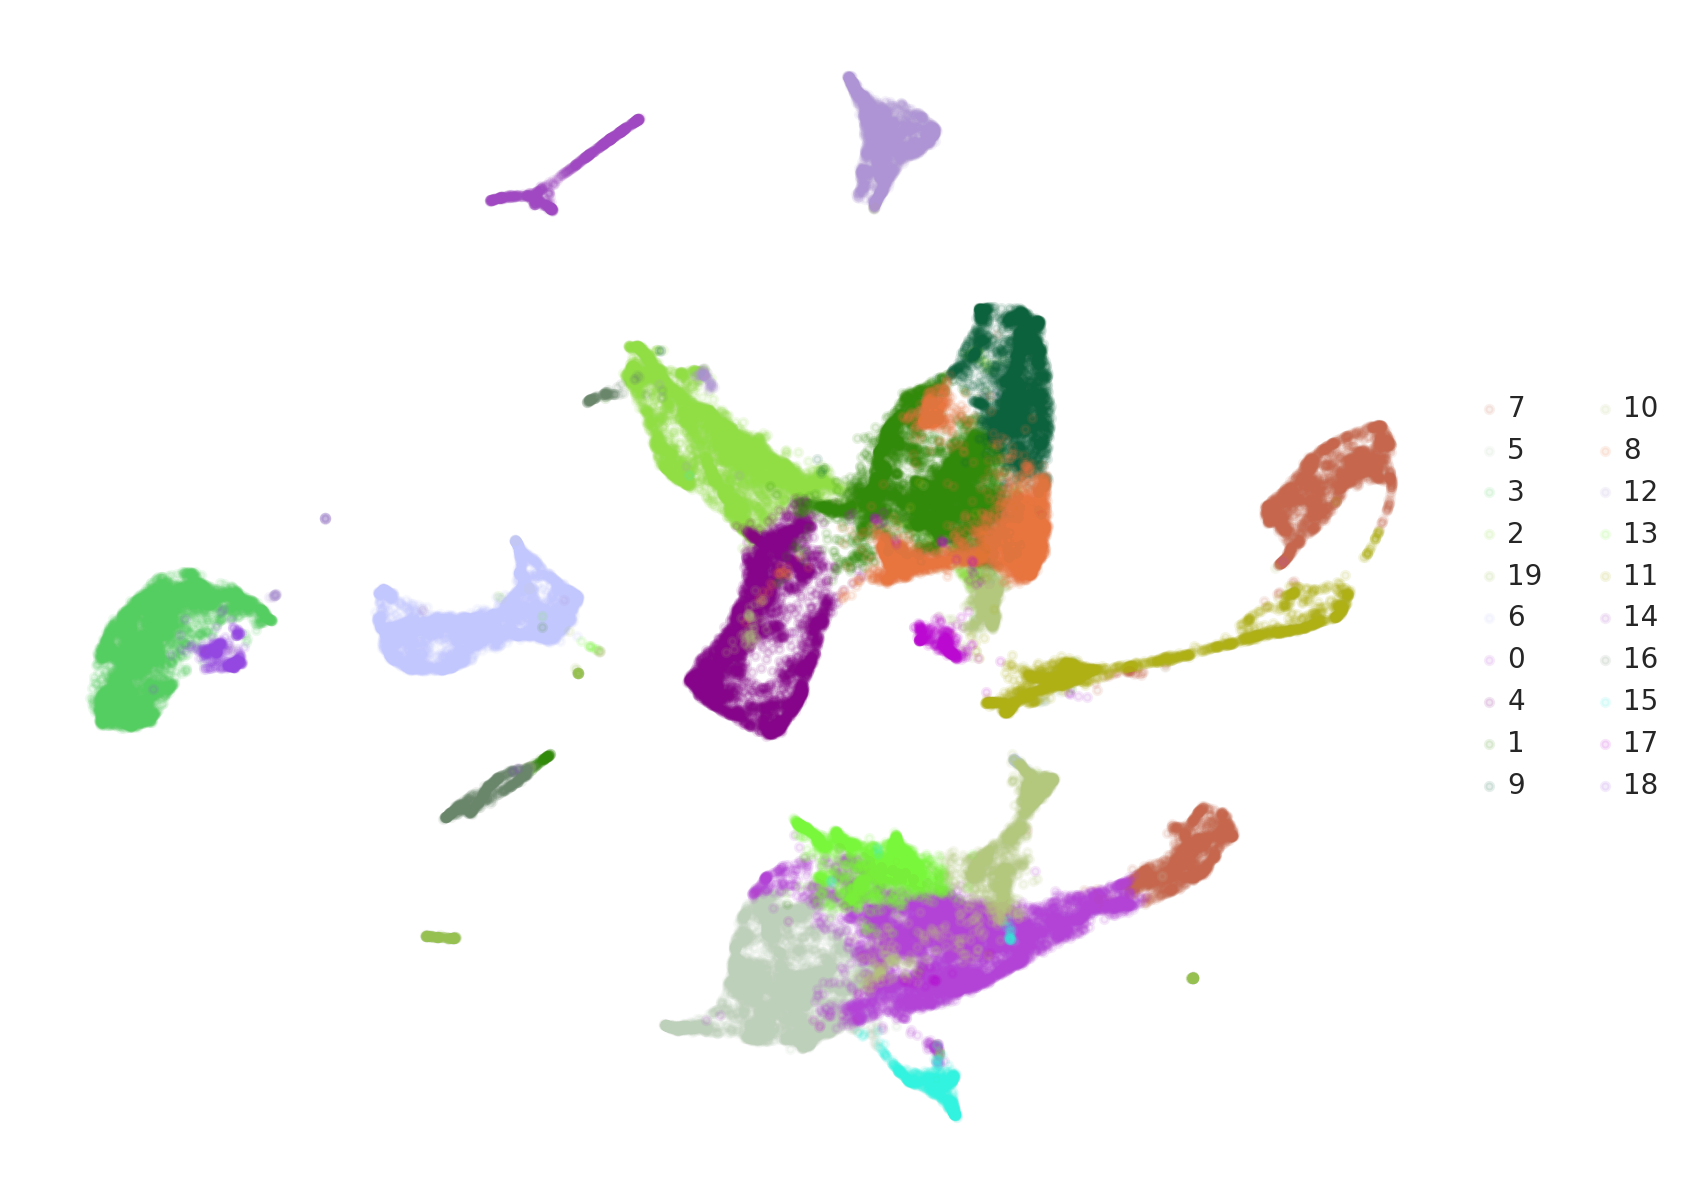

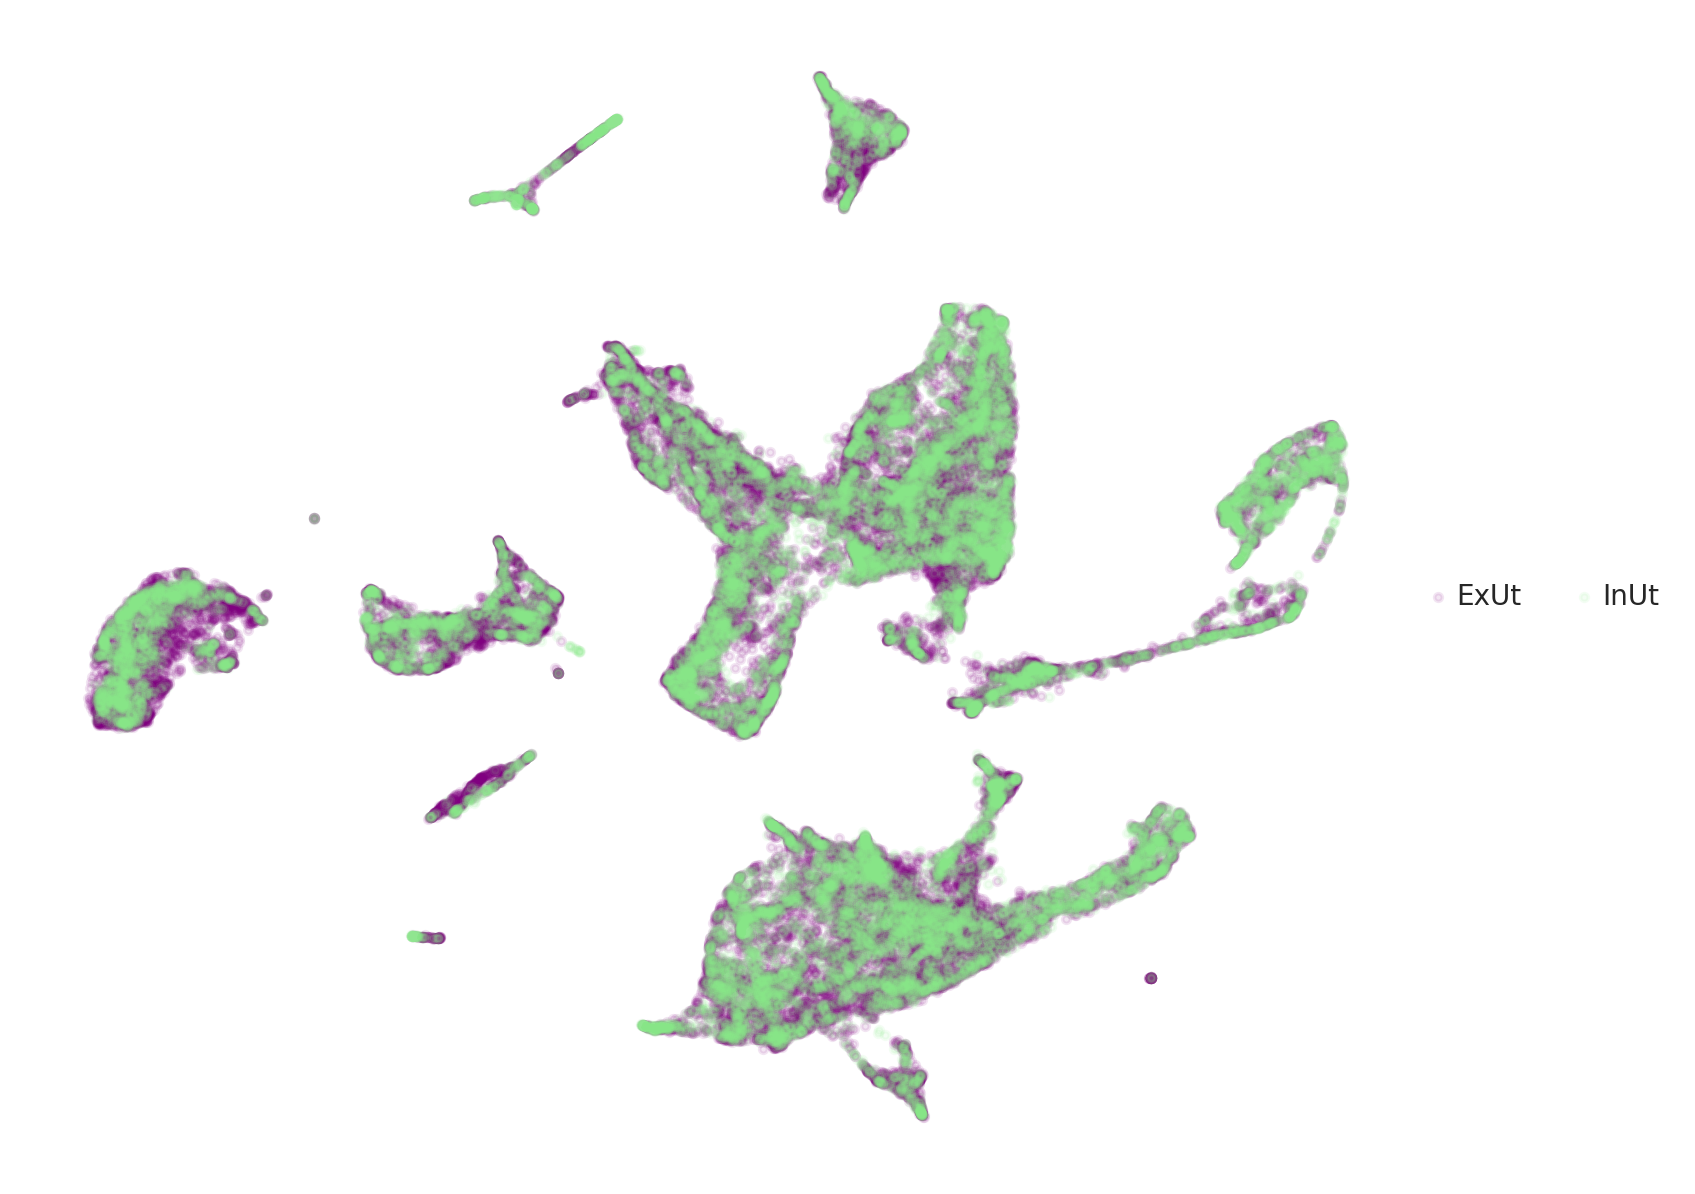

In [ ]:
#Seurat
vis.obj_plot_embed(pcaUMAP ,labs[0], fname = '2DNCA.pdf',colors=colors,alpha = 0.1 )
vis.obj_plot_embed(pcaUMAP, labs[1], fname = '2DNCA.pdf',colors=['purple','lightgreen'],alpha = 0.1)

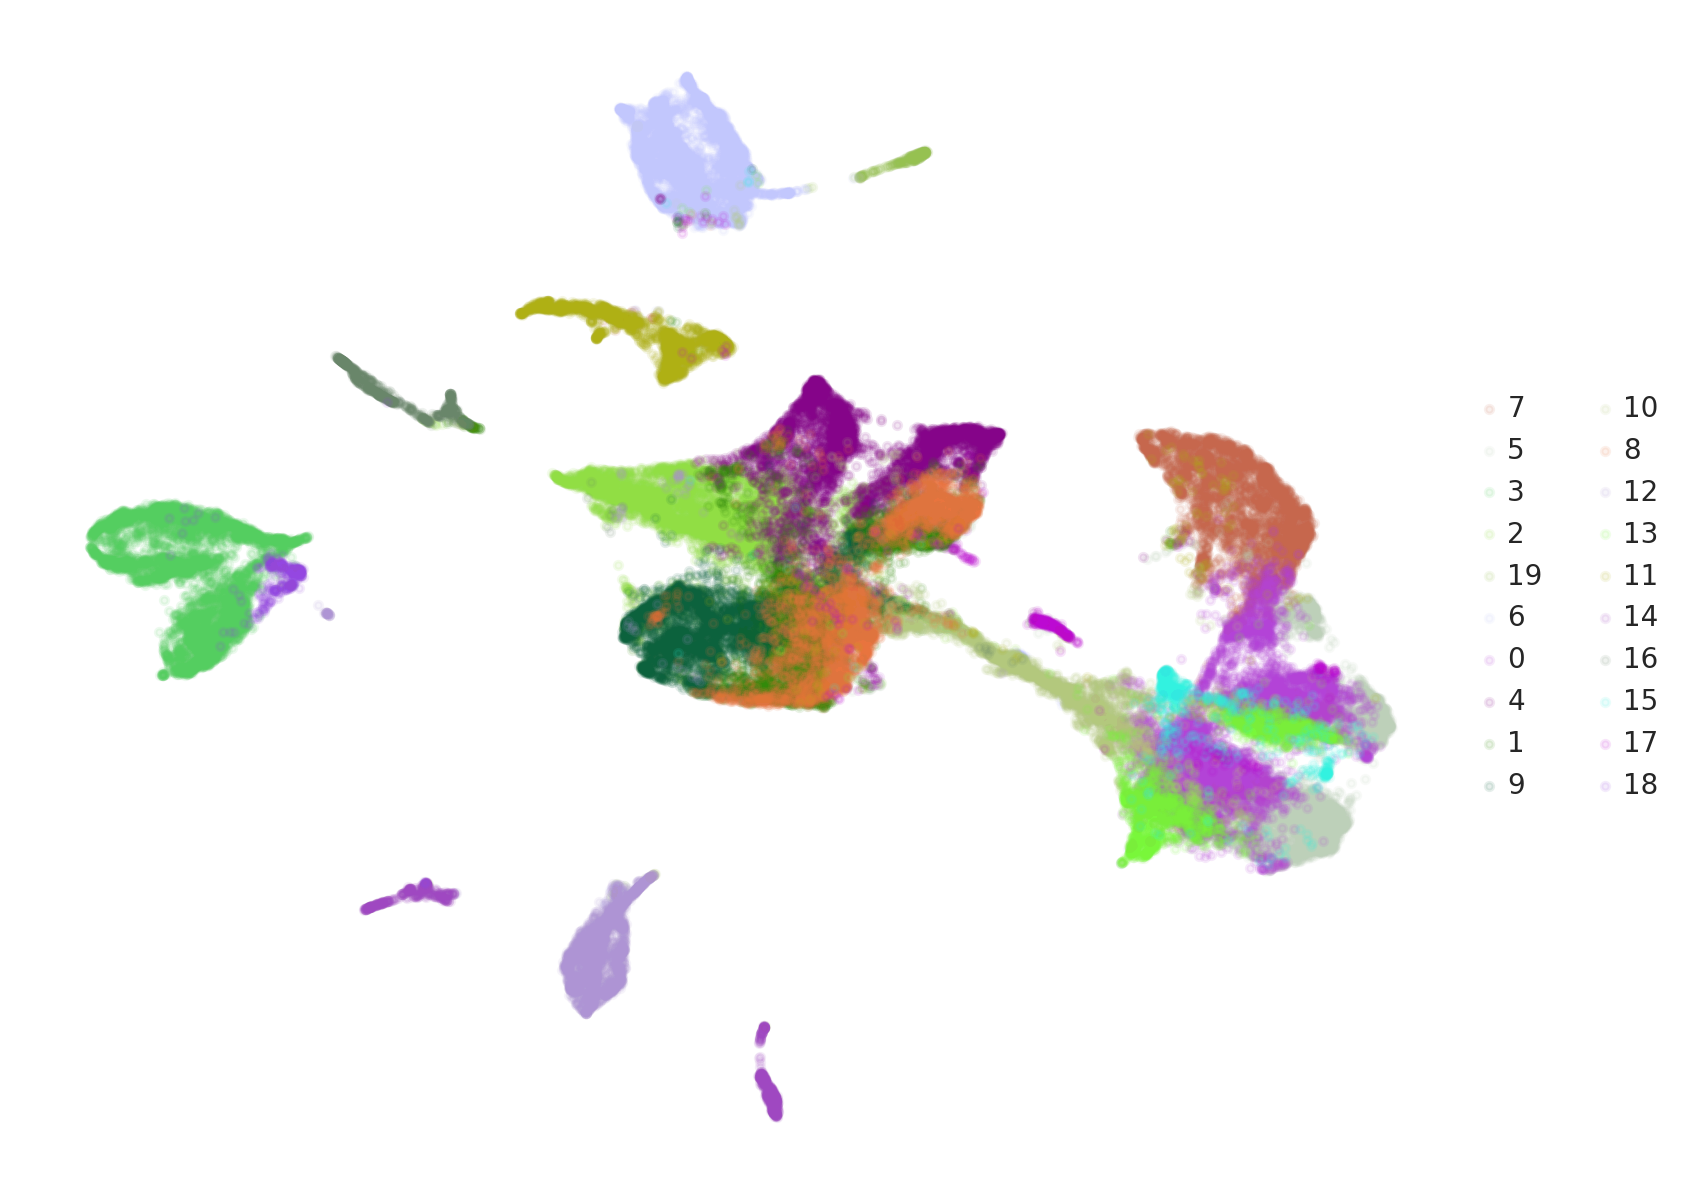

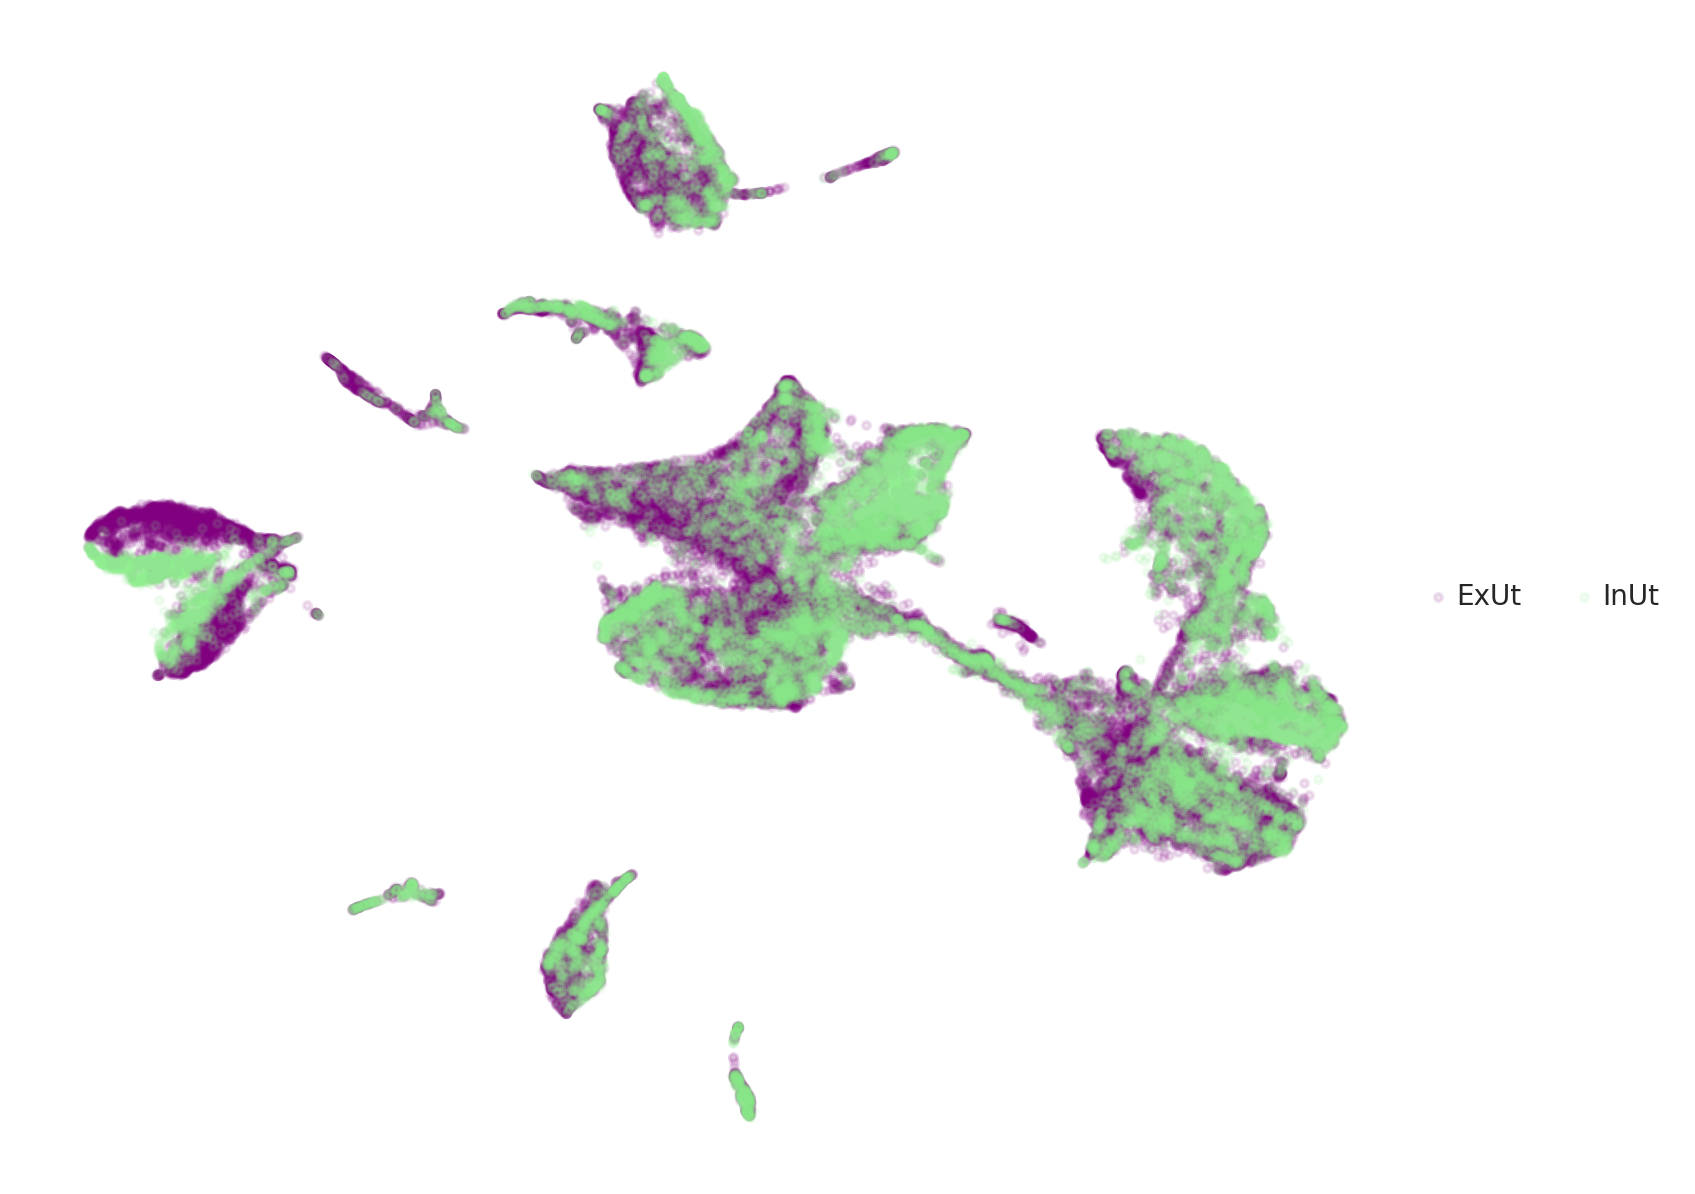

In [ ]:
#Seurat
vis.obj_plot_embed(pcalogUMAP ,labs[0], fname = '2DNCA.pdf',colors=colors ,alpha = 0.1)
vis.obj_plot_embed(pcalogUMAP, labs[1], fname = '2DNCA.pdf',colors=['purple','lightgreen'] ,alpha = 0.1)

#### Fraction of Nearest Neighbors (NNs) with the same label (in Integrated vs tSNE space). Comparing between log or scaled space and tSNE/UMAP space from 15D PCA projection.

In [30]:
def frac_unique_neighbors(latent, cluster_label, metric = 1,neighbors = 30):
    """ Calculates the fraction of nearest neighbors from same cell type
    
    Returns:
    output: dictionary mapping each unique label in the category cluster_label
    to the fraction of neighbors in the same cluster, for each point in the cluster
    """
    cats = pd.Categorical(cluster_label)
    # Get nearest neighbors in each space
    n = neighbors
    neigh = NearestNeighbors(n_neighbors=n, p=metric)
    # Get transformed count matrices
    clusters = np.unique(cluster_label)
    unique_clusters = {}
    frac_neighbors = {}
    X_full  = latent
    neigh.fit(X_full)
    for c in clusters:
        X  = latent[cats == c, :]
        # Find n nearest neighbor cells (L1 distance)
        kNeigh = neigh.kneighbors(X)
        matNeigh = kNeigh[1]
        frac = np.zeros(matNeigh.shape[0])
        #How many of top n neighbors come from same cluster in the labeled data (out of n neighbors)
        unique_clusters[c] = np.unique([cats[matNeigh[i]] for i in range(0, len(frac))])
        frac_neighbors[c] = [cats[matNeigh[i]].value_counts()[c]/n for i in range(0,len(frac))]
    return frac_neighbors, unique_clusters

Next frac_unique_neighbors() steps will take a few hours on Colab

In [31]:
ccaNeigh, ccaClus = frac_unique_neighbors(count_mat, labs[1]) #
#tsneNeigh, tsneClus = frac_unique_neighbors(pcaTSNE, labs[1]) #pcaTSNE2
umapNeigh, umapClus = frac_unique_neighbors(pcaUMAP, labs[1]) #pcaUMAP2 

#latents = [sum(list(ccaNeigh.values()), []),sum(list(tsneNeigh.values()),[]),sum(list(umapNeigh.values()),[]) ]
latents = [sum(list(ccaNeigh.values()), []),sum(list(umapNeigh.values()),[]) ]
latent = ['CCA','UMAP']

In [31]:

#tsneNeigh, tsneClus = frac_unique_neighbors(pcalogTSNE, labs[1]) #pcaTSNE2
umapNeigh, umapClus = frac_unique_neighbors(pcalogUMAP, labs[1]) #pcaUMAP2 
logNeigh, logClus = frac_unique_neighbors(count_mat_orig, labs[1])

#latentsLog = [sum(list(tsneNeigh.values()),[]),sum(list(umapNeigh.values()),[]),sum(list(logNeigh.values()),[]) ]
latentsLog = [sum(list(logNeigh.values()),[]) ,sum(list(umapNeigh.values()),[])]
latentLog = ['Log','UMAP']

In [32]:
#Make dataframe

ccaDF = pd.DataFrame()
ccaDF['Fraction'] = latents[0] + latents[1]
ccaDF['Embed'] = ['Variance Stabilized/Scaled Ambient']*len(latents[0]) + ['15D PCA UMAP']*len(latents[1])
ccaDF.head()

,Fraction,Embed
0,0.200000,Variance Stabilized/Scaled Ambient
1,0.066667,Variance Stabilized/Scaled Ambient
2,0.200000,Variance Stabilized/Scaled Ambient
3,0.133333,Variance Stabilized/Scaled Ambient
4,0.166667,Variance Stabilized/Scaled Ambient


In [37]:
print(statistics.mode(ccaDF['Fraction'][ccaDF['Embed'].isin(['Variance Stabilized/Scaled Ambient'])]))
print(statistics.mode(ccaDF['Fraction'][ccaDF['Embed'].isin(['15D PCA UMAP'])]))


1.0
0.5333333333333333


<Figure size 1250x625 with 0 Axes>

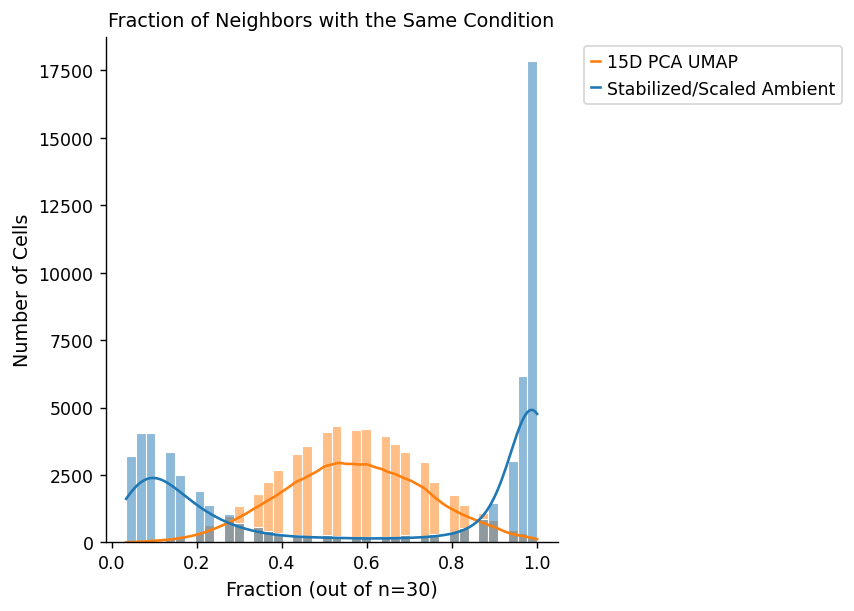

In [41]:
plt.figure(figsize=(10,5))


g=sns.displot(data=ccaDF, x="Fraction", kde=True, hue='Embed',legend=False,edgecolor="white")

plt.legend(['15D PCA UMAP','Stabilized/Scaled Ambient'],bbox_to_anchor=(1.04,1), loc="upper left",prop={"size":10})
plt.title('Fraction of Neighbors with the Same Condition',fontsize=11)

plt.xlabel("Fraction (out of n=30)",fontsize=11)
plt.ylabel("Number of Cells",fontsize=11)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(False)
#plt.tight_layout()
plt.show()

In [32]:
#Make dataframe

ccaDFlog = pd.DataFrame()
ccaDFlog['Fraction'] = latentsLog[0] + latentsLog[1]
ccaDFlog['Embed'] = ['Log-Normalized Ambient']*len(latentsLog[0]) + ['15D PCA UMAP']*len(latentsLog[1])
ccaDFlog.head()

,Fraction,Embed
0,0.466667,Log-Normalized Ambient
1,0.233333,Log-Normalized Ambient
2,0.466667,Log-Normalized Ambient
3,0.966667,Log-Normalized Ambient
4,0.966667,Log-Normalized Ambient


In [34]:
print(statistics.mode(ccaDFlog['Fraction'][ccaDFlog['Embed'].isin(['Log-Normalized Ambient'])]))
print(statistics.mode(ccaDFlog['Fraction'][ccaDFlog['Embed'].isin(['15D PCA UMAP'])]))

0.5333333333333333
1.0


<Figure size 1250x625 with 0 Axes>

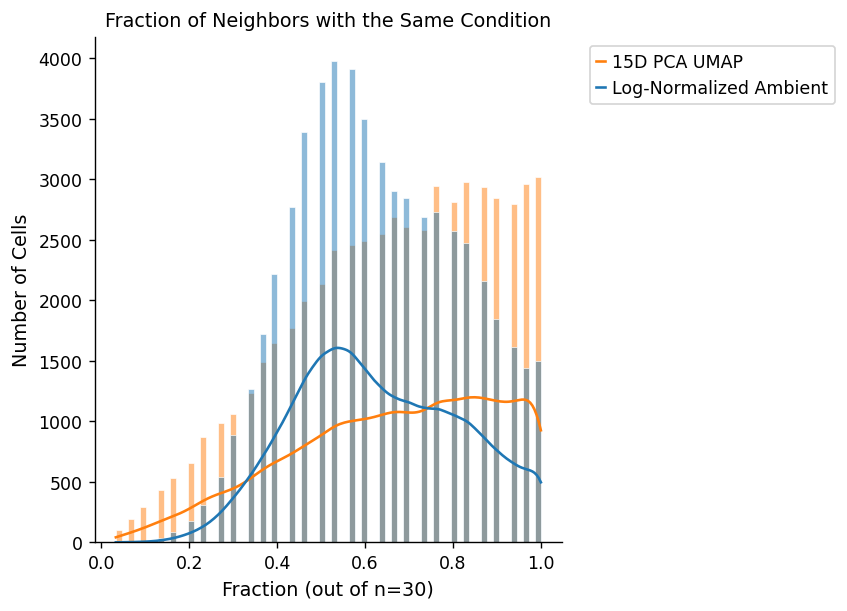

In [37]:
#Test with log-normalized data only


plt.figure(figsize=(10,5))


g=sns.displot(data=ccaDFlog, x="Fraction", kde=True, hue='Embed',legend=False,edgecolor="white")

plt.legend([ '15D PCA UMAP','Log-Normalized Ambient'],bbox_to_anchor=(1.04,1), loc="upper left",prop={"size":10})
plt.title('Fraction of Neighbors with the Same Condition',fontsize=11)

plt.xlabel("Fraction (out of n=30)",fontsize=11)
plt.ylabel("Number of Cells",fontsize=11)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(False)
#plt.tight_layout()
plt.show()



### **Assess Properties of 15D Latent Space with MCML**
Use cell type and condition labels


In [ ]:
rounds = 3

In [ ]:
nc = []
ncLab = []
ncType = []

n_latent = 15

for i in range(rounds):
  nca = MCML(n_latent = n_latent, epochs = 50) #n_latent

  tic = time.perf_counter()
  lossesNCA, latentNCA = nca.fit(scaled_mat,labs, fracNCA = 0.2, silent = True,ret_loss = True) #0.3 --> 0.8 or 0.2
  toc = time.perf_counter()
  print(f"nnNCA fit in {toc - tic:0.4f} seconds")

  nc += [latentNCA]
  ncLab += ['NCA 0.2 MCML']
  ncType += ['MCML 50D']







nnNCA fit in 578.6051 seconds


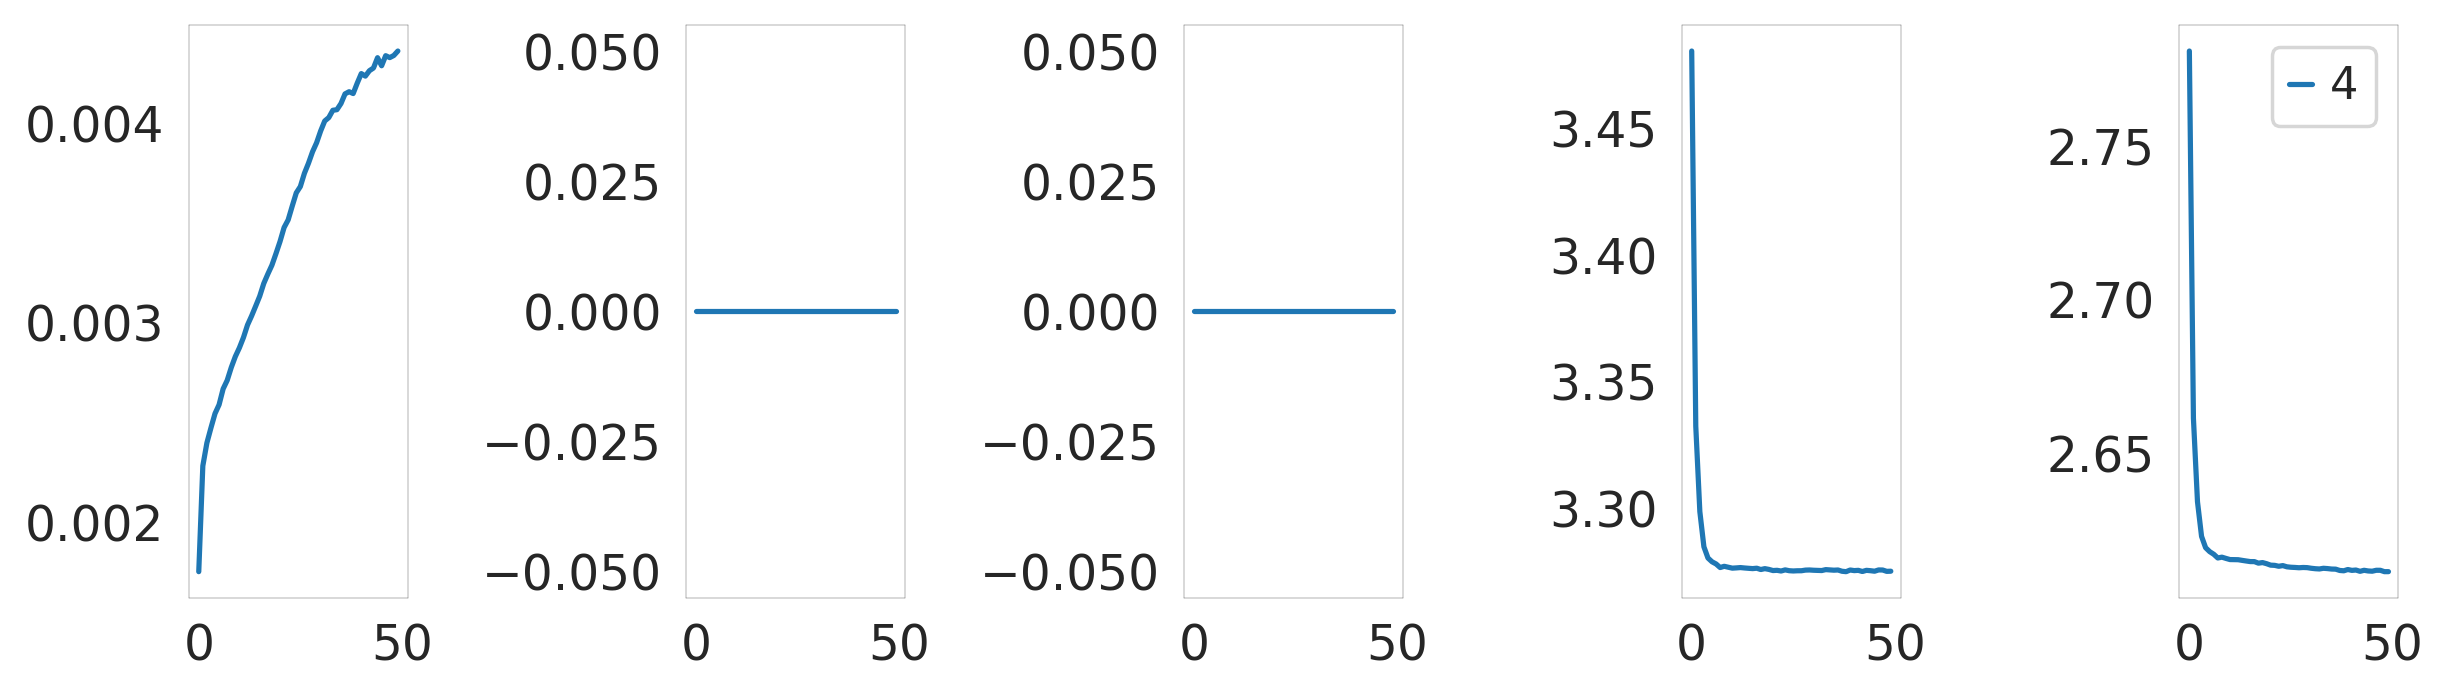

In [ ]:
fig, axs = plt.subplots(1, lossesNCA.shape[1],figsize=(10,3))
for i in range(lossesNCA.shape[1]):
  axs[i].plot(lossesNCA[:,i],label=str(i))
  
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
amb = tl.getCentroidDists(count_mat,labs[0])
ambIntra = tl.getIntraVar(count_mat, labs[0],labs[1])
ambIntraC = tl.getIntraVar(count_mat, labs[0], labs[0])
ambInter = tl.getInterVar(count_mat, labs[0],labs[1])
#latentR, x_pca, x_pca_2d,
#'Recon 50D','PCA 50D','PCA 2D'

In [ ]:
latents,latentLab,latentType = tl.reconComp(scaled_mat, ndims=2, pcs=pcs) #50

In [ ]:
latents = nc + latents #[1:]

latentLab = ncLab + latentLab #[1:]

latentType = ncType + latentType #[1:]

In [ ]:
emb = []

vals = []

dist = []

allVals = pd.DataFrame()

for p in range(len(latents)):

  i = latents[p]
  l = latentLab[p]

  c = tl.getCentroidDists(i, labs[0])
  intra = tl.getIntraVar(i, labs[0], labs[1])
  intraC = tl.getIntraVar(i, labs[0],labs[0])
  inter = tl.getInterVar(i, labs[0], labs[1])



  vals += [stats.pearsonr(c, amb)[0],stats.pearsonr(intra, ambIntra)[0], stats.pearsonr(intraC, ambIntraC)[0], stats.pearsonr(inter, ambInter)[0]]
  #stats.pearsonr(cond, ambCond)[0],stats.pearsonr(intraCond, ambIntraCond)[0]
  dist += ['Inter-Type','Intra-Utero','Intra-Type','Inter-Utero'] 


  emb += [l]*4

allVals['Latent'] = emb
allVals['Distance'] = dist
allVals['Pearsonr'] = vals


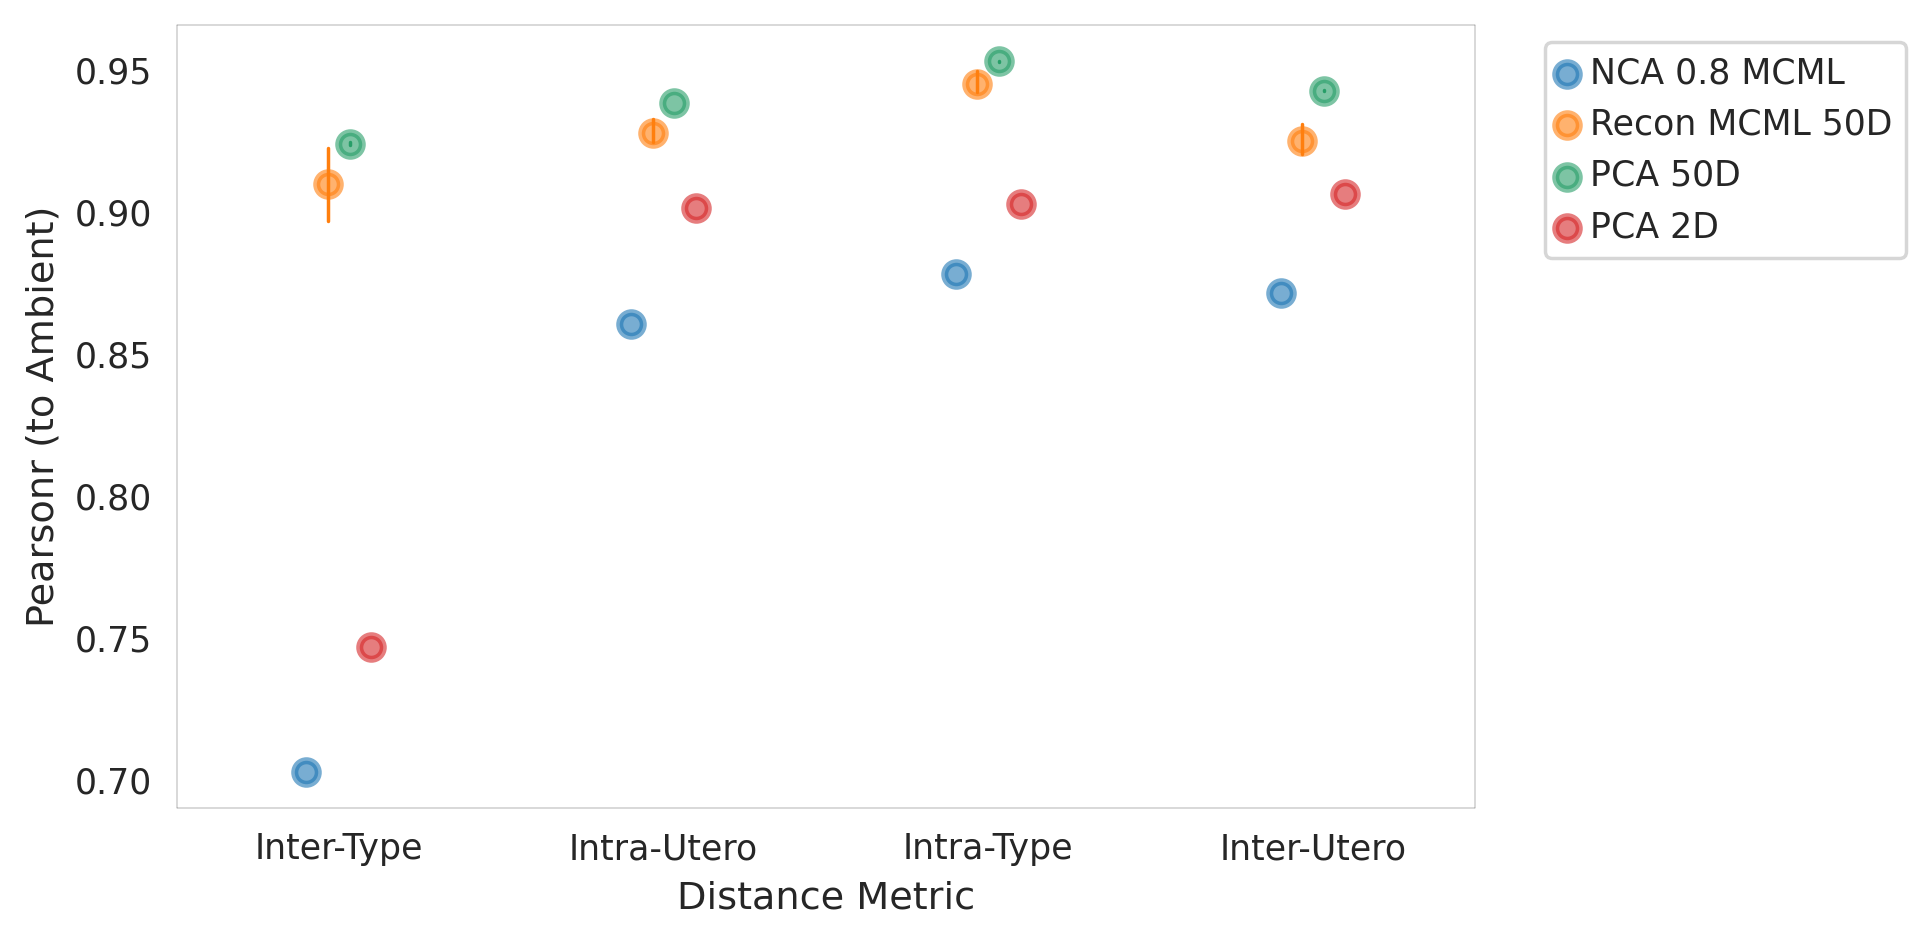

In [ ]:
vis.plotLatentStats(allVals, axisFontSize = 11, tickFontSize = 10, dodge=0.2)

Calculate Centroid Distance within Cell Types (L1 Distance between Ex/In Utero Cells)

In [ ]:
#State vs type
from sklearn.metrics import pairwise_distances

#Distance between conditions within clusters
def getCentroidDists(latent,adata,pair=['ExUt','InUt']):
  clus = list(adata.obs['Cluster'])
  gen = adata.obs['Utero']
  names = np.unique(clus)

  dist = []
  clust = []

  perturbD = 0

  centDists = pd.DataFrame()
  #Within each cell type
  for c in names:
    sub = latent[clus == c,:]
    gen_sub = gen[clus == c]

  #Distance between centroids of chd or tyr cells

    utero1 = sub[gen_sub == pair[0]].mean(axis=0)
    utero2 = sub[gen_sub == pair[1]].mean(axis=0)



    if pair[1] in gen_sub.to_list() and sub[gen_sub == pair[0]].shape[0] > 1:
      perturbD = np.linalg.norm(utero1 - utero2,1)

      dist += [perturbD] #[np.linalg.norm(chdCent - chdTyr,1)]
      clust += [c]

  centDists['Dist'] = dist
  centDists['Type'] = clust
  centDists.head()

  return centDists


In [ ]:
dists = getCentroidDists(nc[0],adata,pair=['ExUt','InUt']) 
dists.sort_values(by='Dist')

,Dist,Type
0,0.374119,0
4,0.393846,4
8,0.409637,8
5,0.417044,5
1,0.461082,1
7,0.488011,7
9,0.537083,9
13,0.537711,13
3,0.626323,3
15,0.665800,15


In [ ]:
# #Example done with 50D, shows same pattern
# dists = getCentroidDists(latentNCA08,adata,pair=['ExUt','InUt']) 
# dists.sort_values(by='Dist')

,Dist,Type
1,1.422608,1
8,1.775309,8
3,1.781007,3
0,1.789344,0
9,1.954933,9
13,2.352976,13
15,2.448793,15
4,2.457963,4
2,2.777408,2
17,2.816278,17


### **Get DE Genes for Clusters with Larger Internal Distances**

In [ ]:
counts2_orig #Using only log-normalized counts to do DE

,AAACCCAAGCCTCACG-1,AAACCCAAGCTCGACC-1,AAACCCAAGTTAACAG-1,AAACCCACACCATATG-1,AAACCCAGTCACGCTG-1,AAACCCAGTGCGTTTA-1,AAACCCAGTGGCTCTG-1,AAACCCATCCCATAGA-1,AAACGAAAGAAGCTCG-1,AAACGAAAGACTAAGT-1,AAACGAACACCATTCC-1,AAACGAACATCGCCTT-1,AAACGAAGTAGCGCTC-1,AAACGAAGTTCGGTAT-1,AAACGAATCTGGGATT-1,AAACGCTAGAGACAAG-1,AAACGCTAGATGTTAG-1,AAACGCTAGGGCCAAT-1,AAACGCTAGTAGAGTT-1,AAACGCTCAGACCCGT-1,AAACGCTCAGTGCCTG-1,AAACGCTCATTGCAAC-1,AAACGCTGTTTCCATT-1,AAAGAACCACATGGTT-1,AAAGAACCAGGTCAGA-1,AAAGAACGTCCTGGTG-1,AAAGAACTCCACAGGC-1,AAAGAACTCCACTGGG-1,AAAGAACTCTACAGGT-1,AAAGAACTCTCCGAGG-1,AAAGGGCAGAGGGTAA-1,AAAGGGCAGCAAACAT-1,AAAGGGCAGGATTTAG-1,AAAGGGCCAAGATTGA-1,AAAGGGCCAGCCTACG-1,AAAGGGCGTTTACTGG-1,AAAGGTAAGTAATTGG-1,AAAGGTACAACACTAC-1,AAAGGTACAACTACGT-1,AAAGGTAGTAGTCGTT-1,...,TTTCACAAGGAGCAAA-12,TTTCACACACTCTAGA-12,TTTCACATCCATGATG-12,TTTCACATCTGCTCTG-12,TTTCAGTTCATGCATG-12,TTTCATGCAGATAAAC-12,TTTCATGTCACGATCA-12,TTTCCTCAGACCATTC-12,TTTCCTCAGTAGCATA-12,TTTCCTCCAAACACCT-12,TTTCCTCGTAACCAGG-12,TTTCCTCGTGGCTGCT-12,TTTCCTCTCTTCGTAT-12,TTTCGATAGAAGCGAA-12,TTTCGATAGGCTAAAT-12,TTTCGATGTGGGACAT-12,TTTGACTCACACAGAG-12,TTTGACTCAGCTATAC-12,TTTGACTGTAGTCTTG-12,TTTGACTGTGGCTGCT-12,TTTGACTGTTTCGCTC-12,TTTGACTTCTGACAGT-12,TTTGATCAGGACACTG-12,TTTGATCCACACTGGC-12,TTTGATCCAGGAATAT-12,TTTGATCCAGTCGCAC-12,TTTGATCGTGAGAGGG-12,TTTGATCTCACGGGCT-12,TTTGATCTCATAAGGA-12,TTTGGAGGTGGAGGTT-12,TTTGGAGTCCCGAGTG-12,TTTGGTTAGTCTAACC-12,TTTGGTTCACAAAGCG-12,TTTGGTTGTATGAGGC-12,TTTGGTTTCGTGGCTG-12,TTTGTTGAGCAGCGAT-12,TTTGTTGCAGTCCGTG-12,TTTGTTGCAGTTCACA-12,TTTGTTGGTCGTGTTA-12,TTTGTTGTCCAACCAA-12
Xkr4,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
Rp1,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
Sox17,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.879883,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
Mrpl15,0.0,1.244141,0.887695,0.706543,0.796875,0.0,0.791504,0.946777,1.662109,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.328125,1.121094,0.0,0.000000,1.511719,1.797852,1.269531,0.624023,1.047852,0.0,0.0,0.0,1.121094,1.490234,0.789551,0.0,1.27832,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,1.180664,0.97998,1.339844,0.0,0.0,0.0,1.006836,0.0,1.366211,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,1.306641,0.0,0.000000,1.047852,0.0,1.452148,0.000000,1.651367,1.004883,0.000000,0.0,0.0
Lypla1,0.0,0.000000,0.000000,0.414551,0.000000,0.0,0.000000,0.581543,1.142578,1.78418,0.0,1.063477,1.029297,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.121094,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.

In [ ]:
#Subset log-normalized data for specific clusters of interest
count_mat_orig2 = counts2_orig.values.T
for16 = count_mat_orig2[adata.obs['Cluster'] == 16,:]
for19 = count_mat_orig2[adata.obs['Cluster'] == 19,:]

In [ ]:
#Cluster 16 counts - Myocytes
sub16 = anndata.AnnData(X =for16)
sub16.obs_names = list(adata[adata.obs['Cluster'] == 16].obs_names)
sub16.var_names = list(counts2_orig.index)
sub16.obs['Utero'] = pd.Categorical(cellMeta.Utero[cellMeta['integrated_snn_res.0.3'] == 16])

sub16

AnnData object with n_obs × n_vars = 641 × 21164
    obs: 'Utero'

In [ ]:
#Cluster 19 counts - hepatocytes
sub19 = anndata.AnnData(X =for19)
sub19.obs_names = list(adata[adata.obs['Cluster'] == 19].obs_names)
sub19.var_names = list(counts2_orig.index)
sub19.obs['Utero'] = pd.Categorical(cellMeta.Utero[cellMeta['integrated_snn_res.0.3'] == 19])

sub19

AnnData object with n_obs × n_vars = 204 × 21164
    obs: 'Utero'

In [ ]:
method = 'wilcoxon'
sc.tl.rank_genes_groups(sub16, 'Utero', method=method)
sc.tl.rank_genes_groups(sub19, 'Utero', method=method)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Make dataframes of DE genes in clusters 16 and 19 that meet DE requirements from original study

In [ ]:
sub16Plot = pd.DataFrame()

sub16Plot['log2FC'] = sub16.uns['rank_genes_groups']['logfoldchanges']['ExUt'].tolist()
sub16Plot['padj'] = sub16.uns['rank_genes_groups']['pvals_adj']['ExUt'].tolist()
sub16Plot['Name'] = sub16.uns['rank_genes_groups']['names']['ExUt'].tolist()

sub16Plot = sub16Plot[~np.isnan(sub16Plot.log2FC)]

sub16Plot = sub16Plot[abs(sub16Plot.log2FC) < 10]


sub16Plot['logpadj'] = -np.log10(sub16Plot['padj'])
sub16Plot.head() 


,log2FC,padj,Name,logpadj
0,1.594669,5.218241e-32,Gapdh,31.282476
1,2.197152,6.262080e-31,Pgk1,30.203281
2,2.585664,2.135260e-26,Rpl29,25.670549
3,1.364678,5.741862e-19,Aldoa,18.240947
4,1.539050,1.775244e-18,Ldha,17.750742


In [ ]:
sub16Sig = sub16Plot[sub16Plot['logpadj'] > 1.3]
sub16Sig.sort_values('log2FC',ascending=False)

,log2FC,padj,Name,logpadj
52,4.770008,3.663689e-06,Slc2a3,5.436081
114,4.667099,1.187314e-03,Nppb,2.925435
119,4.578878,1.269532e-03,Ndufa4l2,2.896356
27,3.878647,1.799510e-09,Krt19,8.744846
101,3.863460,5.704632e-04,Ier3,3.243772
...,...,...,...,...
21070,-3.082197,7.598749e-04,Ankrd2,3.119258
20985,-3.265124,3.221095e-02,Serinc2,1.491996
21065,-3.530615,1.026492e-03,Tubb3,2.988644
21154,-3.698803,6.524336e-10,Myog,9.185464


In [ ]:
sub19Plot = pd.DataFrame()

sub19Plot['log2FC'] = sub19.uns['rank_genes_groups']['logfoldchanges']['ExUt'].tolist()
sub19Plot['padj'] = sub19.uns['rank_genes_groups']['pvals_adj']['ExUt'].tolist()
sub19Plot['Name'] = sub19.uns['rank_genes_groups']['names']['ExUt'].tolist()

sub19Plot = sub19Plot[~np.isnan(sub19Plot.log2FC)]

sub19Plot = sub19Plot[abs(sub19Plot.log2FC) < 10]

sub19Plot['logpadj'] = -np.log10(sub19Plot['padj'])
sub19Plot.head() 

,log2FC,padj,Name,logpadj
0,0.966889,9.805142e-08,Ftl1,7.008546
1,1.781851,3.961558e-07,Rpl29,6.402134
2,0.702129,1.446930e-06,Rps24,5.839552
3,1.386098,1.972772e-06,mt-Co1,5.704923
4,0.534090,1.972772e-06,Rpsa,5.704923


In [ ]:
sub19Sig = sub19Plot[sub19Plot['logpadj'] > 1.3]
sub19Sig.sort_values('log2FC',ascending=False)

,log2FC,padj,Name,logpadj
1,1.781851,3.961558e-07,Rpl29,6.402134
5,1.683957,7.337627e-06,Tmsb10,5.134444
3,1.386098,1.972772e-06,mt-Co1,5.704923
10,1.367095,4.225192e-03,Rcn3,2.374154
19,1.266138,2.710560e-02,Serpinh1,1.566941
20,1.229738,3.018131e-02,Gm11361,1.520262
13,1.159163,7.327882e-03,Rpl10,2.135022
18,1.134162,2.223696e-02,Fam162a,1.652925
0,0.966889,9.805142e-08,Ftl1,7.008546
25,0.879028,4.679078e-02,Ndufv3,1.329840


Volcano plots for DE genes

In [ ]:
def retSig(p,fc):

  if p > 1.3 and abs(fc) > 0.5:
    return 'Sig'
  else:
    return 'notSig'

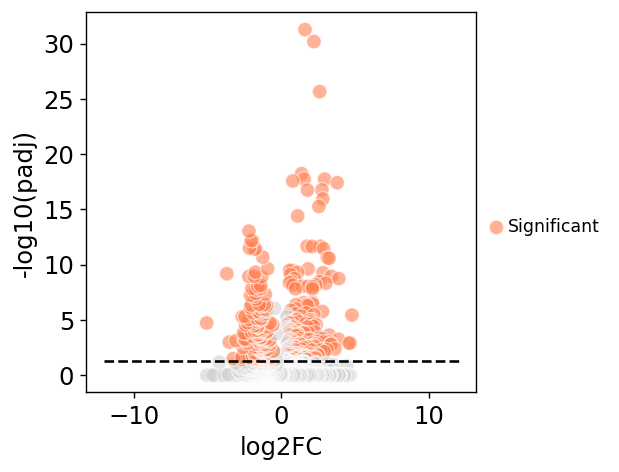

In [ ]:
#sub["val"] =sub['Genes'].apply(lambda x: "green" if x in ['XLOC_006558','XLOC_006729','XLOC_000601'] else "blue")

sub16Plot["notSig"] =sub16Plot.apply(lambda x: retSig(x.logpadj, x.log2FC),axis=1)


ax = sns.scatterplot(data=sub16Plot, x='log2FC',y='logpadj',alpha=0.6,hue='notSig',palette={"notSig":"lightgrey","Sig":"coral"},s=70,legend = False)
ax.legend(title='', loc='upper left', labels=['Significant', 'Not Significant'],bbox_to_anchor=(1, 0.5),prop={'size': 10},frameon=False)

ax.set_ylabel('-log10(padj)')
ax.hlines([1.3], -12, 12, linestyles='dashed', colors='black')
plt.grid(False)
plt.savefig('de16.pdf')


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn

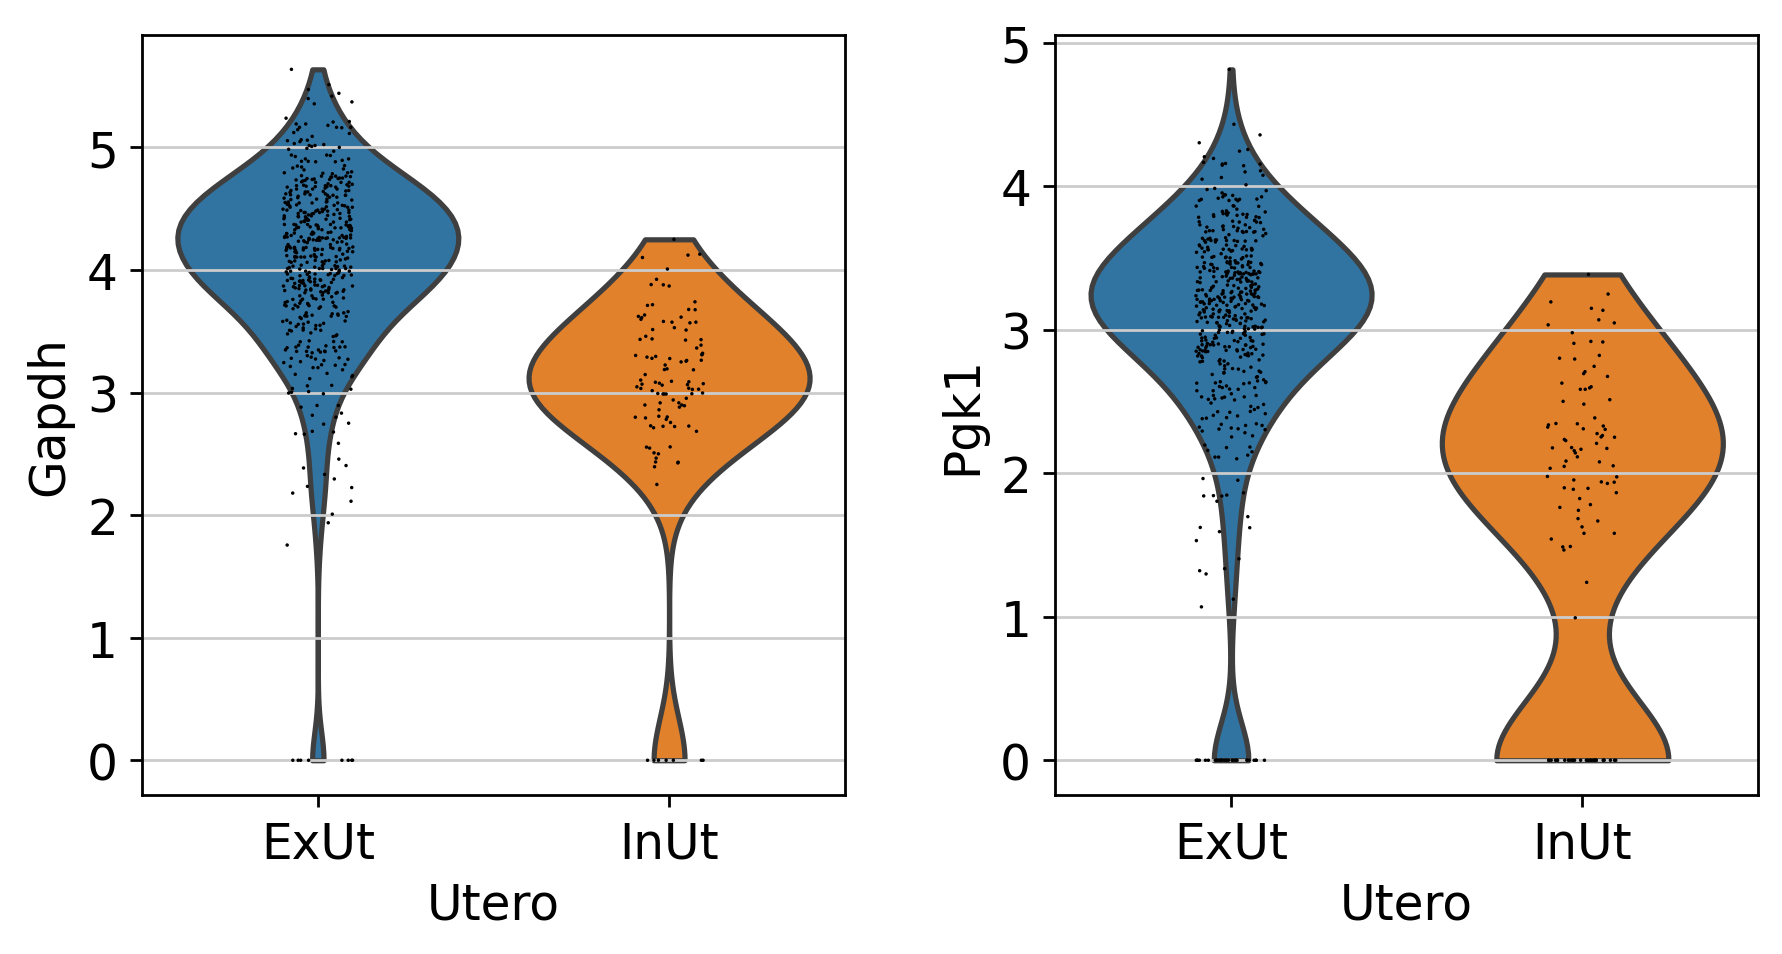

In [ ]:
sc.pl.violin(sub16,keys=['Gapdh','Pgk1'],groupby='Utero')

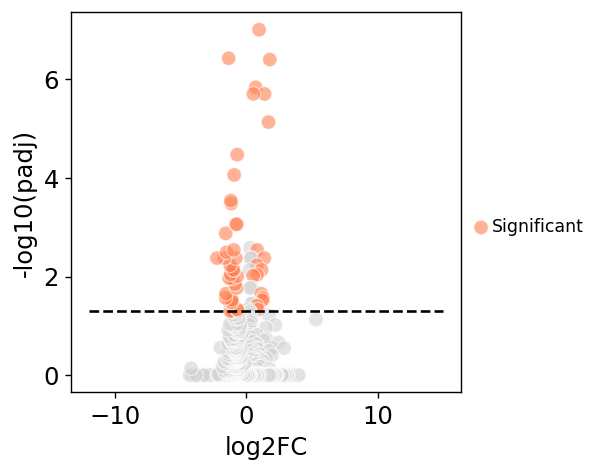

In [ ]:

#sub["val"] =sub['Genes'].apply(lambda x: "green" if x in ['XLOC_006558','XLOC_006729','XLOC_000601'] else "blue")
sub19Plot["notSig"] =sub19Plot.apply(lambda x: retSig(x.logpadj, x.log2FC),axis=1)

ax = sns.scatterplot(data=sub19Plot, x='log2FC',y='logpadj',alpha=0.6,hue='notSig', palette={"notSig":"lightgrey","Sig":"coral"},legend=False,s=70)
ax.legend(title='', loc='upper left', labels=['Significant', 'Not Significant'],bbox_to_anchor=(1, 0.5),prop={'size': 10},frameon=False)
ax.set_ylabel('-log10(padj)')
ax.hlines([1.3], -12, 15, linestyles='dashed', colors='black')
plt.grid(False)
plt.savefig('de19.pdf')


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn

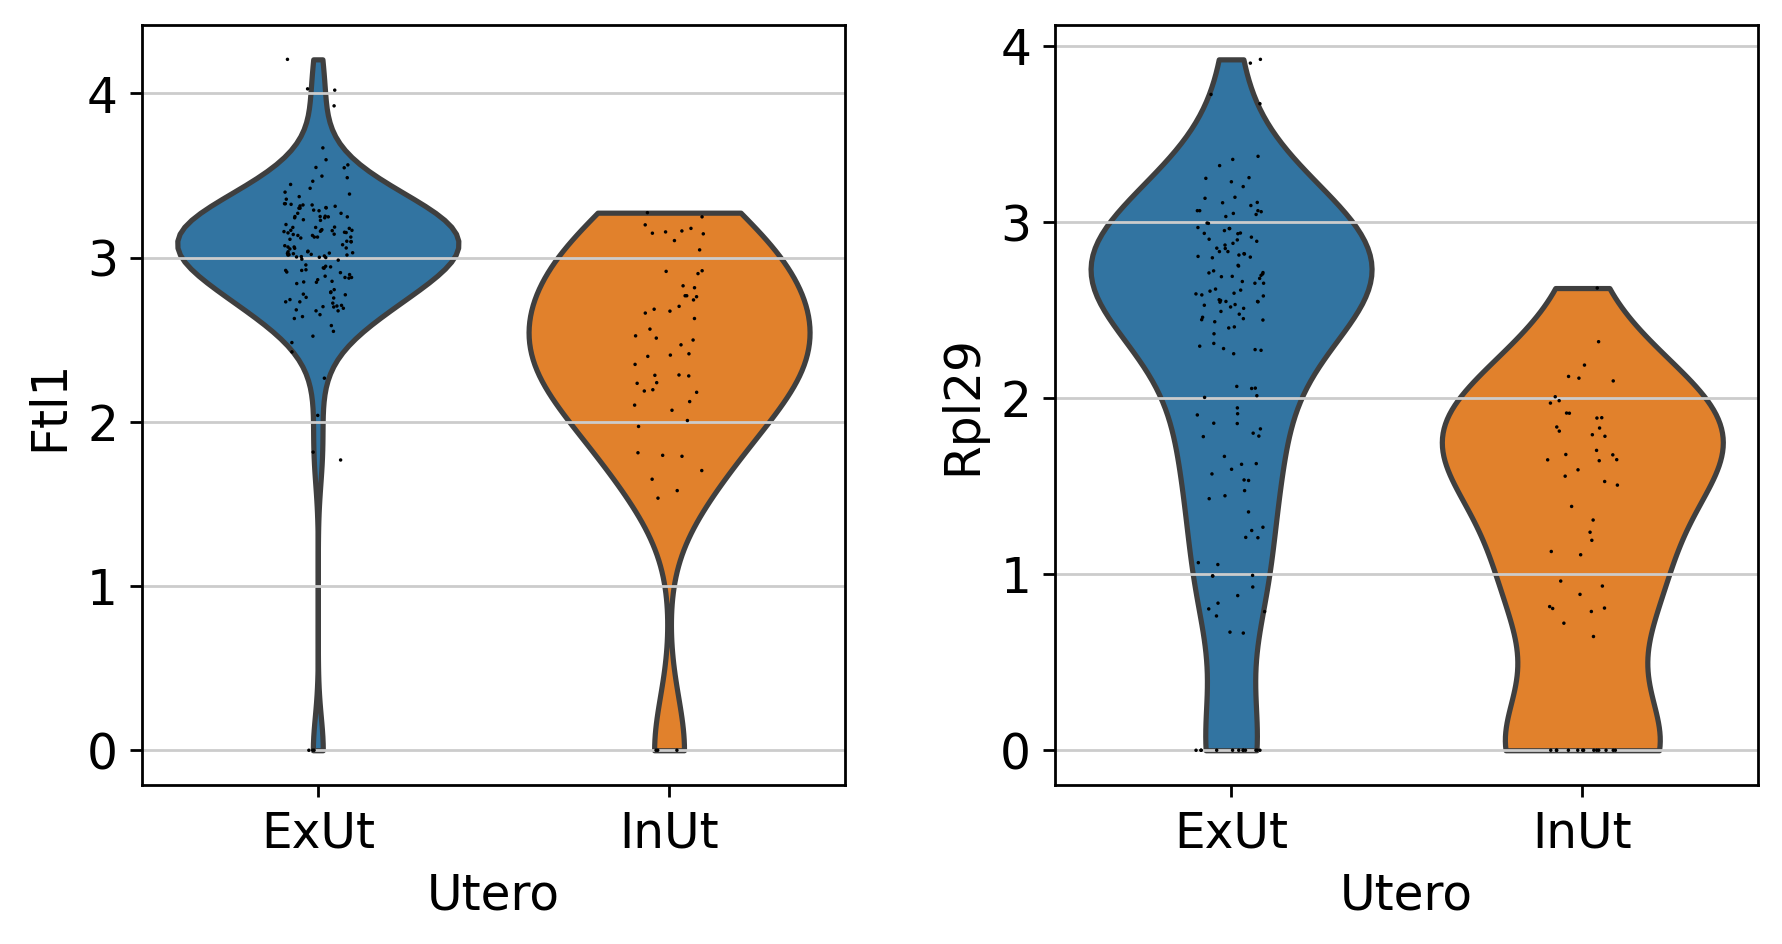

In [ ]:
sc.pl.violin(sub19,keys=['Ftl1','Rpl29'],groupby='Utero')

In [ ]:
adata2.X.shape

(56528, 2000)